# Image Quality Assessment

## Compute metrics (SSIM and PSNR)

In [13]:
import os
import numpy as np
import nibabel as nib
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to load .nii.gz images
def load_nifti(path):
    """
    Load NiFTI (nii.gz) image.
    
    :param path: Path to image.

    :return:
        3D numpy array
        Prints progress messages for each processed file
    """
    return nib.load(path).get_fdata().astype(np.float32)

# Function to compute SSIM
def ssim_skimage(synth_mri, real_mri):
    """
    Compute SSIM using skimage.metrics.ssim() for each MRI slice,
    then computes the average SSIM for the full scan.

    :param synth_mri:
    :param real_mri:

    :return: Mean SSIM for full scan (float).
    """
    depth = synth_mri.shape[2]
    ssim_scores = []

    # Iterate through slices
    for i in range(depth):
        slice1 = synth_mri[:, :, i]
        slice2 = real_mri[:, :, i]

        # Skip slices with only background
        if np.all(slice1 == 0) and np.all(slice2 == 0):
            continue

        # Compute SSIM and append to list
        ssim_val = ssim(slice1, slice2, data_range=1.0, multichannel=False)
        ssim_scores.append(ssim_val)

    # Compute mean SSIM with slice SSIM
    return float(np.mean(ssim_scores))

In [14]:
import csv

# Data directories
real_dir  = r"D:\image_quality_evaluation\processed_real"
synth_dir = r"D:\image_quality_evaluation\processed_synth"

# List to append different results
results = []

# Iterate through directories and pick subject
for subject in sorted(os.listdir(synth_root)):
    synth_folder = os.path.join(synth_root, subject)
    real_folder  = os.path.join(real_root, subject)

    print(f"Processing: {subject}")

    # Load all real images in a dict
    real_imgs = {f: load_nifti(os.path.join(real_folder, f))
                for f in os.listdir(real_folder)
                if f.endswith((".nii", ".nii.gz"))}

    # Loop synthetic images
    for synth_file in sorted(os.listdir(synth_folder)):
        synth_path = os.path.join(synth_folder, synth_file)
        synth_img  = load_nifti(synth_path)

        # Create empty variables to store results
        best_ssim = -1
        best_real_file = None
        best_psnr = None

        # Compare with all real images
        for real_name, real_img in real_imgs.items():
            ssim_val = ssim_skimage(synth_img, real_img)
            psnr_val = psnr(real_img, synth_img, data_range=1.0)

            # Update best synthetic-real SSIM
            if ssim_val > best_ssim:
                best_ssim = ssim_val
                best_real_file = real_name
                best_psnr = psnr_val

        # Save the best SSIM
        results.append([subject,
                        synth_file,
                        best_real_file,
                        best_ssim,
                        best_psnr])


# Save results into CSV
with open("quality_assessment.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["subject", "synthetic_image", "best_coincidence_real_image", "ssim", "psnr"])
    writer.writerows(results)

print("Results saved.")

Processing: OAS30014_MR_d0196
Processing: OAS30017_MR_d0054
Processing: OAS30025_MR_d0210
Processing: OAS30036_MR_d0059
Processing: OAS30039_MR_d1203
Processing: OAS30052_MR_d0693
Processing: OAS30078_MR_d0210
Processing: OAS30083_MR_d0465
Processing: OAS30087_MR_d0260
Processing: OAS30099_MR_d0032
Processing: OAS30102_MR_d0024
Processing: OAS30104_MR_d0328
Processing: OAS30107_MR_d0387
Processing: OAS30125_MR_d0201
Processing: OAS30127_MR_d0098
Processing: OAS30134_MR_d0080
Processing: OAS30140_MR_d0172
Processing: OAS30147_MR_d0048
Processing: OAS30165_MR_d1763
Processing: OAS30167_MR_d0111
Processing: OAS30176_MR_d0000
Processing: OAS30195_MR_d1596
Processing: OAS30226_MR_d0183
Processing: OAS30234_MR_d2098
Processing: OAS30238_MR_d0037
Processing: OAS30250_MR_d0389
Processing: OAS30262_MR_d0037
Processing: OAS30274_MR_d3332
Processing: OAS30292_MR_d0165
Processing: OAS30297_MR_d1712
Processing: OAS30300_MR_d0100
Processing: OAS30302_MR_d0262
Processing: OAS30306_MR_d0028
Processing

## Data overview

In [15]:
import pandas as pd

results = pd.read_csv("quality_assessment.csv")

results.head()


,subject,synthetic_image,best_coincidence_real_image,ssim,psnr
0,OAS30014_MR_d0196,OAS30014_MR_d0196_synth_brain_10_0000_preproce...,sub-OAS30014_ses-d0196_run-01_T1w_stripped_pre...,0.831667,17.791601
1,OAS30014_MR_d0196,OAS30014_MR_d0196_synth_brain_1_0000_preproces...,sub-OAS30014_ses-d0196_run-02_T1w_stripped_pre...,0.826636,19.443428
2,OAS30014_MR_d0196,OAS30014_MR_d0196_synth_brain_2_0000_preproces...,sub-OAS30014_ses-d0196_run-01_T1w_stripped_pre...,0.795353,18.218005
3,OAS30014_MR_d0196,OAS30014_MR_d0196_synth_brain_3_0000_preproces...,sub-OAS30014_ses-d0196_run-02_T1w_stripped_pre...,0.838332,19.353450
4,OAS30014_MR_d0196,OAS30014_MR_d0196_synth_brain_4_0000_preproces...,sub-OAS30014_ses-d0196_run-01_T1w_stripped_pre...,0.826954,18.630994


In [16]:
results.describe()

,ssim,psnr
count,500.000000,500.000000
mean,0.823017,18.331556
std,0.018142,1.060563
min,0.764329,15.657131
25%,0.810545,17.580435
50%,0.823043,18.246072
75%,0.833952,18.969776
max,0.877086,22.857842


## Intensity evaluation

In [5]:
# Data directories
synth_root = r"D:\image_quality_evaluation\processed_synth"
real_root = r"D:\image_quality_evaluation\processed_real"

# Empty lists to collect intensities
synth_values = []
real_values = []

# Iterate through all the folders
for subject in sorted(os.listdir(synth_root)):
    synth_folder = os.path.join(synth_root, subject)
    real_folder = os.path.join(real_root, subject)

    # Load real MRI
    for f in os.listdir(real_folder):
        if f.endswith((".nii", ".nii.gz")):
            real = nib.load(os.path.join(real_folder, f)).get_fdata().astype(np.float32)
            r = real.flatten()
            r = r[r > 0]   # Remove background
            real_values.append(r)

    # Load synthetic MRI
    for f in os.listdir(synth_folder):
        if f.endswith((".nii", ".nii.gz")):
            synth = nib.load(os.path.join(synth_folder, f)).get_fdata().astype(np.float32)
            s = synth.flatten()
            s = s[s > 0]   # Remove background
            synth_values.append(s)

# Concatenate all voxel values
real_values = np.concatenate(real_values)
synth_values = np.concatenate(synth_values)

# Real image statistics
real_mean = np.mean(real_values)
real_std = np.std(real_values)
real_min = np.min(real_values)
real_max = np.max(real_values)
real_median = np.median(real_values)
real_p0_5 = np.percentile(real_values, 0.5)
real_p99_5 = np.percentile(real_values, 99.5)

# Synthetic image statistics
synth_mean = np.mean(synth_values)
synth_std = np.std(synth_values)
synth_min = np.min(synth_values)
synth_max = np.max(synth_values)
synth_median = np.median(synth_values)
synth_p0_5 = np.percentile(synth_values, 0.5)
synth_p99_5 = np.percentile(synth_values, 99.5)

# Print results
print("Real MRI:")
print(f"mean: {real_mean:.4f}")
print(f"std: {real_std:.4f}")
print(f"min: {real_min:.4f}")
print(f"max: {real_max:.4f}")
print(f"median: {real_median:.4f}")
print(f"p0.5: {real_p0_5:.4f}")
print(f"p99.5: {real_p99_5:.4f}")

print("Synthetic MRI")
print(f"mean: {synth_mean:.4f}")
print(f"std: {synth_std:.4f}")
print(f"min: {synth_min:.4f}")
print(f"max: {synth_max:.4f}")
print(f"median: {synth_median:.4f}")
print(f"p0.5: {synth_p0_5:.4f}")
print(f"p99.5: {synth_p99_5:.4f}")

Real MRI:
mean: 0.4727
std: 0.2486
min: 0.0019
max: 1.0000
median: 0.4480
p0.5: 0.0207
p99.5: 1.0000
Synthetic MRI
mean: 0.4648
std: 0.2822
min: 0.0040
max: 1.0000
median: 0.4563
p0.5: 0.0133
p99.5: 1.0000


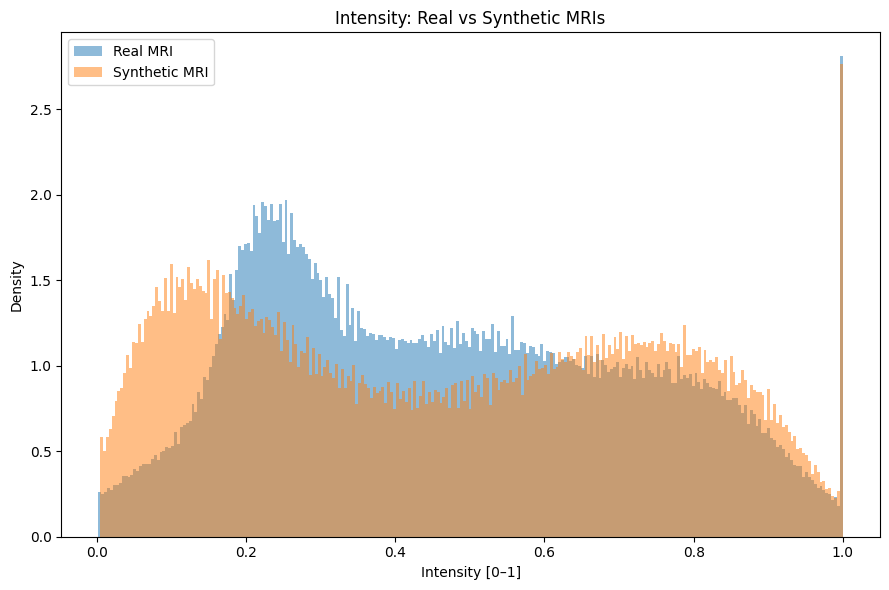

In [46]:
import matplotlib.pyplot as plt

# Data directories
synth_root = r"D:\image_quality_evaluation\processed_synth"
real_root = r"D:\image_quality_evaluation\processed_real"

# Empty lists to collect intensities
synth_values = []
real_values = []

# Iterate through all the folders
for subject in sorted(os.listdir(synth_root)):
    synth_folder = os.path.join(synth_root, subject)
    real_folder = os.path.join(real_root, subject)

    # Load real MRI
    for f in os.listdir(real_folder):
        if f.endswith((".nii", ".nii.gz")):
            real = nib.load(os.path.join(real_folder, f)).get_fdata().astype(np.float32)
            r = real.flatten()
            r = r[r > 0]   # Remove background
            real_values.append(r)

    # Load synthetic MRI, flatten, remove background, append voxel intensities
    for f in os.listdir(synth_folder):
        if f.endswith((".nii", ".nii.gz")):
            synth = nib.load(os.path.join(synth_folder, f)).get_fdata().astype(np.float32)
            s = synth.flatten()
            s = s[s > 0]
            synth_values.append(s)

# Concatenate values in arrays
real_values = np.concatenate(real_values)
synth_values = np.concatenate(synth_values)

# Plot results
plt.figure(figsize=(9,6))
plt.hist(real_values, bins=256, alpha=0.5, density=True, label="Real MRI")
plt.hist(synth_values, bins=256, alpha=0.5, density=True, label="Synthetic MRI")
plt.title("Intensity: Real vs Synthetic MRIs")
plt.xlabel("Intensity [0–1]")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("histogram_psnr_vs_ssim.png")
plt.show()

## Violin plot with SSIM distribution per contrast

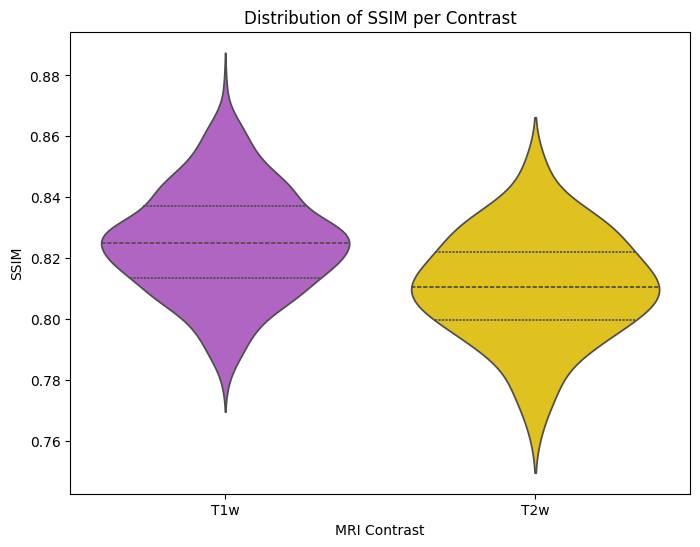

In [40]:
import seaborn as sns

# Extract contrast type from filename
results["contrast"] = results["best_coincidence_real_image"].str.extract(r"(T1w|T2w)")

plt.figure(figsize=(8,6))
sns.violinplot(x="contrast", y="ssim", data=results, inner="quartile", hue="contrast", palette={"T1w":"mediumorchid", "T2w":"gold"})
plt.xlabel("MRI Contrast")
plt.ylabel("SSIM")
plt.title("Distribution of SSIM per Contrast")
plt.savefig("violin_ssim.png")
plt.show()

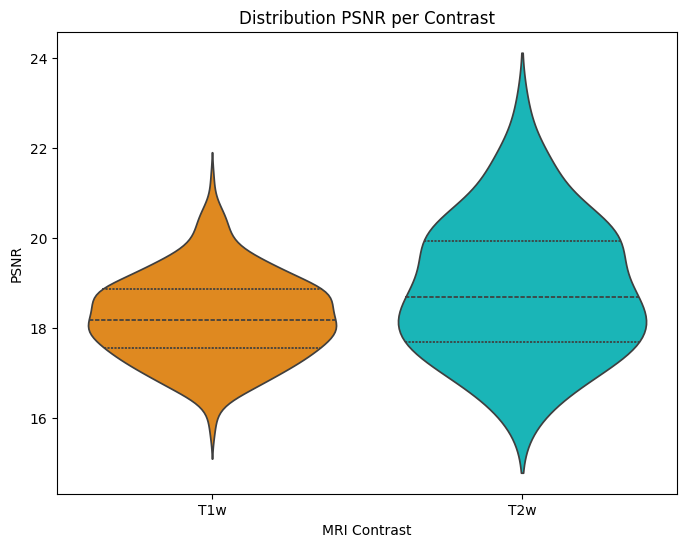

In [41]:
plt.figure(figsize=(8,6))
sns.violinplot(x="contrast", y="psnr", data=results, inner="quartile", hue="contrast", palette={"T1w":"darkorange", "T2w":"darkturquoise"})
plt.xlabel("MRI Contrast")
plt.ylabel("PSNR")
plt.title("Distribution PSNR per Contrast")
plt.savefig("violin_psnr.png")
plt.show()

## PSNR vs SSIM

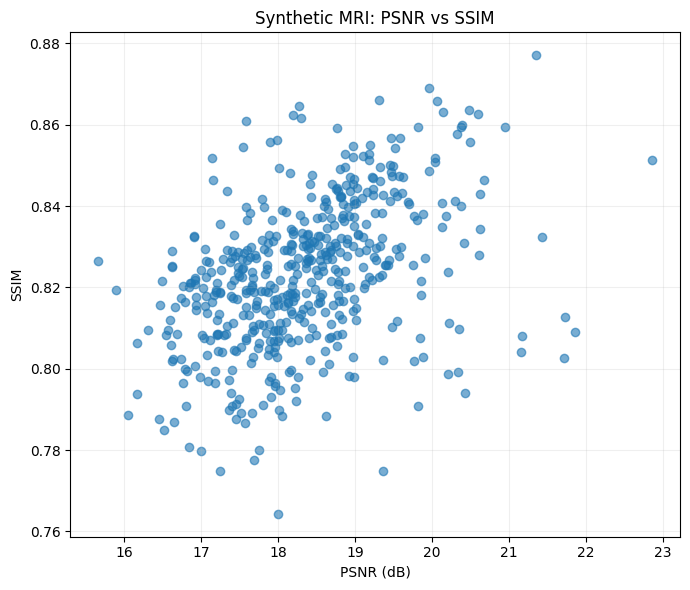

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.scatter(results["psnr"], results["ssim"], alpha=0.6)
plt.xlabel("PSNR (dB)")
plt.ylabel("SSIM")
plt.title("Synthetic MRI: PSNR vs SSIM")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("scatterplot_psnr_ssim.png")
plt.show()

In [49]:
stats_ssim = results.groupby("contrast")["ssim"].agg(min="min", max="max", mean="mean", std="std").reset_index()
print(stats_ssim)

  contrast       min       max      mean       std
0      T1w  0.779853  0.877086  0.825078  0.017439
1      T2w  0.764329  0.851398  0.810768  0.017504


In [48]:
stats_psnr = results.groupby("contrast")["psnr"].agg(min="min", max="max", mean="mean", std="std").reset_index()
print(stats_psnr)

  contrast        min        max       mean       std
0      T1w  15.657131  21.349146  18.237434  0.940758
1      T2w  16.047854  22.857842  18.891058  1.487201


## Confusion Matrices per ROI

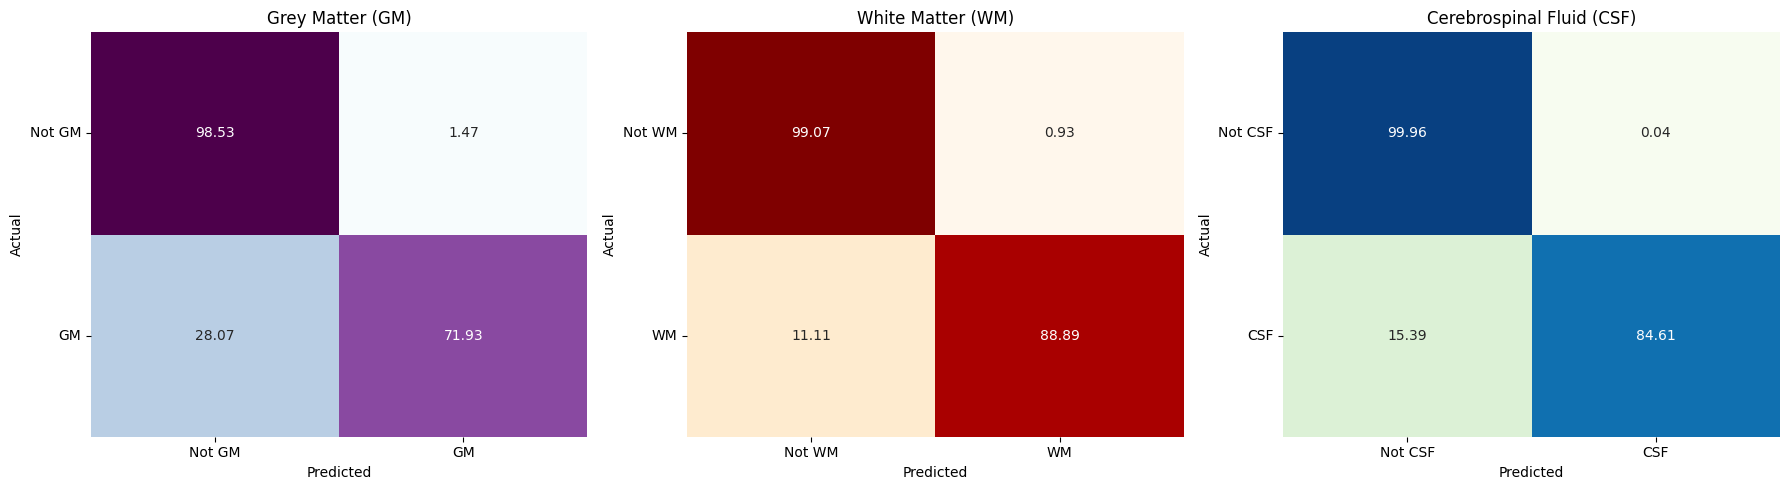

In [8]:
# Confusion matrices
cm_gm = np.array([[15987574.61, 238918.32],
                  [154597.32, 396125.96]])

cm_wm = np.array([[16157053.53, 151574.15],
                  [52081.94, 416506.58]])

cm_csf = np.array([[16729767.18, 6911.65],
                   [6236.94, 34300.23]])

# Percentage
cm_gm_percent = cm_gm / cm_gm.sum(axis=1, keepdims=True) * 100
cm_wm_percent = cm_wm / cm_wm.sum(axis=1, keepdims=True) * 100
cm_csf_percent = cm_csf / cm_csf.sum(axis=1, keepdims=True) * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#GM
sns.heatmap(cm_gm_percent, annot=True, fmt=".2f", cmap="BuPu", cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_xticks([0.5,1.5])
axes[0].set_xticklabels(["Not GM", "GM"])
axes[0].set_yticks([0.5,1.5])
axes[0].set_yticklabels(["Not GM", "GM"], rotation=0)
axes[0].set_title("Grey Matter (GM)")

# WM
sns.heatmap(cm_wm_percent, annot=True, fmt=".2f", cmap="OrRd", cbar=False, ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_xticks([0.5,1.5])
axes[1].set_xticklabels(["Not WM", "WM"])
axes[1].set_yticks([0.5,1.5])
axes[1].set_yticklabels(["Not WM", "WM"], rotation=0)
axes[1].set_title("White Matter (WM)")

# CSF
sns.heatmap(cm_csf_percent, annot=True, fmt=".2f", cmap="GnBu", cbar=False, ax=axes[2])
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")
axes[2].set_xticks([0.5,1.5])
axes[2].set_xticklabels(["Not CSF", "CSF"])
axes[2].set_yticks([0.5,1.5])
axes[2].set_yticklabels(["Not CSF", "CSF"], rotation=0)
axes[2].set_title("Cerebrospinal Fluid (CSF)")

plt.tight_layout()
plt.savefig("confmatrix.png")
plt.show()